# 삼성 주가 분석

## 1. 시계열 데이터 준비

- 칼럼 종류 : Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있다.
- 우리는 종가(Close)만 사용하겠다.(주식 시장은 정해진 시간 동안만 거래가 가능하다. 종가란 하루의 장이 마감했을 때의 가격이다.)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import statsmodels
import sklearn

import warnings
warnings.filterwarnings('ignore')

In [3]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

In [4]:
ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

## 2. 각종 필요한 전처리 

- 결측치 확인
- 로그 변환

In [5]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [6]:
# 로그 변환
ts_log = np.log(ts)

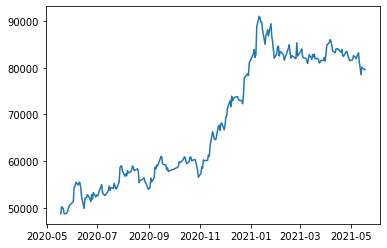

In [7]:
plt.plot(ts)

로그 변환을 했지만 그래프의 분포를 보면 추세가 있는 것을 알 수 있다. 그리고 평균이 일정하지 않기 때문에 시계열 분해를 해야 될 것 같다.

## 3. 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

### 필요한 함수 정의 
- 이동평균과 이동표준편차 함수 
- Augmented Dicky-Fuller Test함수 

In [8]:
def plot_rolling_statics(timeseries, window=12):
  rolmean = timeseries.rolling(window=window).mean()
  rolstd = timeseries.rolling(window=window).std()

  orig = plt.plot(timeseries, color = 'blue', label ='Original')
  mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
  std = plt.plot(rolstd, color = 'black', label ='Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)


plot_rolling_statics는 시계열을 plot으로 바꾸는 함수이다. rolmean, rolstd는 이동평균과 이동표준편차이고 그에 맞게 원본, 이동평균, 이동표준편차 순으로 plot을 그리는 함수이다. 

In [9]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
  dftest = adfuller(timeseries, autolag='AIC')

  print('Results of Dickey-Fuller Test:')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statisic', 'p-value', '#Lags Used', 'Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key] = value
  print(dfoutput)

adfuller함수를 호출해서 검정통계량이 Critical Value보다 작으면 Stationary한 시계열 데이터라고 할 수 있다. 혹은 p-value가 설정한 신뢰수준 값보다 작으면 stationary한 시계열 데이터라고 할 수 있다.

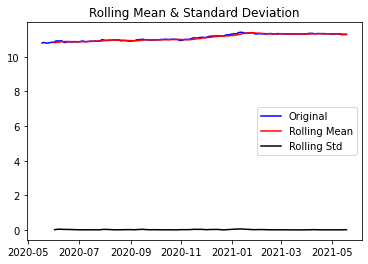

Results of Dickey-Fuller Test:
Test Statisic                   -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


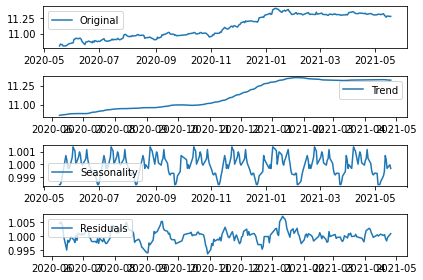

In [10]:
# 정성적 그래프 분석
plot_rolling_statics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

앞서 설명한 Adfuller()함수를 통해서 위 시계열 데이터가 Critical Value보다 전부 낮게 나왔기 때문에 우리는 시계열 데이터가 Stationary하다고 판단할 수 있다. 우선 d 파라미터를 0이라 생각하고 다음 단계로 넘어간다.

In [11]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statisic                 -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


## 4. 학습, 테스트 데이터셋 생성

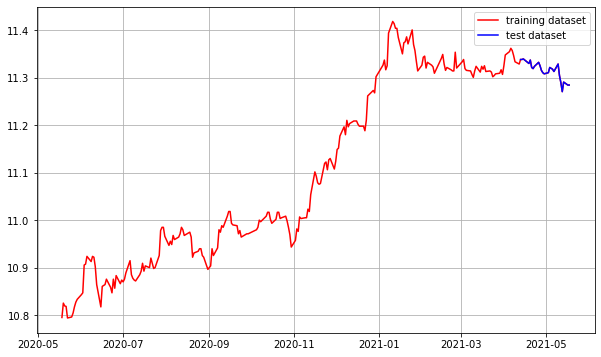

In [12]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset') 
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## 5. 적정 ARIMA 모수 찾기

- ACF,PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

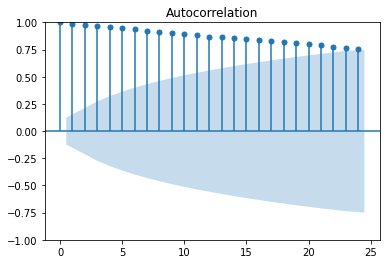

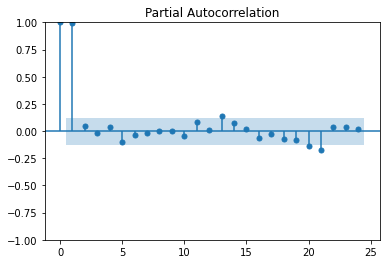

In [13]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

하지만 ACF를 살펴보면 천천히 줄어드는 것을 확인할 수 있는데 이는 비정상성을 확인할 수 있다는 의미이다. 그래처 차분을 통해 정상성을 가지는지 확인한다. 이러면 d 파라미터가 0이라고 확신할 수 없다. 그리고 PACFplot을 살펴보면 lag1이후로 0이되는 것을 확인할 수 있다. 일단 p파라미터를 1이라고 생각할 수 있다. 허나 여러 시도를 통해서 최적의 값을 찾을 수 있기 때문에 1로 확정하지는 않고 여러 시도를 해본다.

Results of Dickey-Fuller Test:
Test Statisic                 -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statisic                 -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


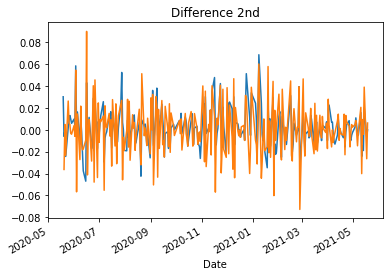

In [14]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

차분을 해보니 이상치들이 조금 눈에 보이긴 하지만, 좀더 정상성을 띄는 것을 확인할 수 있다. 그래서 d 파라미터를 0이라고 확정할 수 없을 거 같다. d파라미터도 여러 시도를 해보는 것이 좋을 것 같다.

## 6. ARIMA 모델 훈련과 테스트

- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [15]:
from statsmodels.tsa.arima.model import ARIMA 
import warnings
warnings.simplefilter('ignore')

model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Mon, 25 Jul 2022   AIC                          -1156.722
Time:                        01:28:18   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

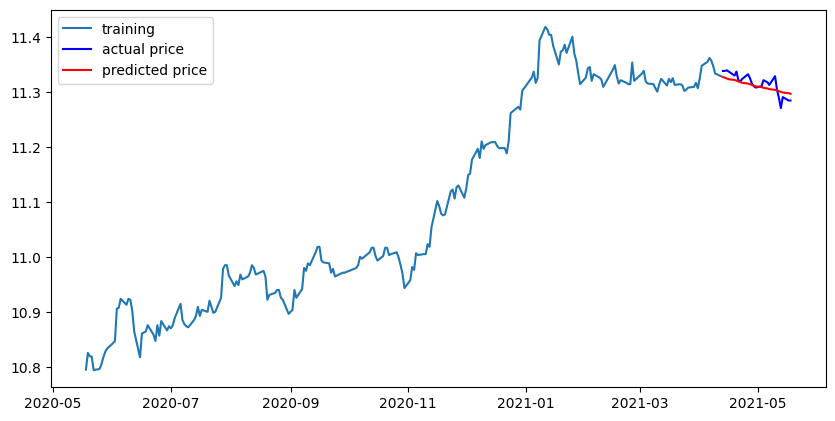

In [16]:
import warnings
warnings.simplefilter('ignore')

fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1048973.6014239907
MAE:  843.7579531508708
RMSE:  1024.19412292006
MAPE: 1.03%


MAPE는 퍼센트 값을 가지며 0에 가까울수록 회귀모형의 성능이 좋다는 것을 의미한다. 그래서 MAPE값의 최저가 되는 값을 여러 시도 끝에 찾았다. 나는 p 파라미터를 1, d파라미터를0으로 상정했으나 p 파라미터 2, d 파라미터 0, q파라미터 0에서 최적의 MAPE값을 얻게 됐다.

# 네이버 주가 분석

## 1. 시계열 데이터 준비

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import statsmodels
import sklearn

import warnings
warnings.filterwarnings('ignore')

In [19]:
dataset_naver_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/035420.KS.csv'
df_naver = pd.read_csv(dataset_naver_filepath, index_col='Date', parse_dates=True)
ts_naver = df_naver['Close']

In [20]:
ts_naver.head()

Date
2021-07-22    440000.0
2021-07-23    452000.0
2021-07-26    452000.0
2021-07-27    452000.0
2021-07-28    442000.0
Name: Close, dtype: float64

## 2. 각종 필요한 전처리

- 결측치 확인
- 로그 변환

In [21]:
# 결측치 확인
ts_naver = ts_naver.interpolate(method='time')
ts_naver[ts_naver.isna()]

Series([], Name: Close, dtype: float64)

In [22]:
# 로그 변환
ts_naver_log = np.log(ts_naver)

## 3. 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

### 필요한 함수 정의 
- 이동평균과 이동표준편차 함수 
- Augmented Dicky-Fuller Test함수 

In [23]:
def plot_rolling_statics(timeseries, window=12):
  rolmean = timeseries.rolling(window=window).mean()
  rolstd = timeseries.rolling(window=window).std()

  orig = plt.plot(timeseries, color = 'blue', label ='Original')
  mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
  std = plt.plot(rolstd, color = 'black', label ='Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)

In [24]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
  dftest = adfuller(timeseries, autolag='AIC')

  print('Results of Dickey-Fuller Test:')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statisic', 'p-value', '#Lags Used', 'Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key] = value
  print(dfoutput)

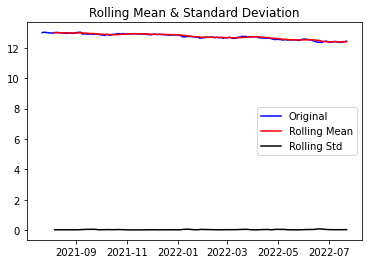

Results of Dickey-Fuller Test:
Test Statisic                   -0.585017
p-value                          0.874332
#Lags Used                       4.000000
Number of Observations Used    240.000000
Critical Value (1%)             -3.457894
Critical Value (5%)             -2.873659
Critical Value (10%)            -2.573229
dtype: float64


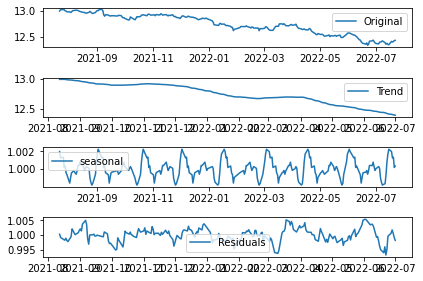

In [25]:
# 정성적 그래프 분석
plot_rolling_statics(ts_naver_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_naver_log)

# 시계열 분해(Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
naver_decomposition = seasonal_decompose(ts_naver_log, model= 'multiplicative', period=30)

trend = naver_decomposition.trend
seasonal = naver_decomposition.seasonal
residual = naver_decomposition.resid

plt.subplot(411)
plt.plot(ts_naver_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc='best')
plt.tight_layout()

Adfuller함수를 통해 우리는 위 자료가 Stationary한 시계열 데이터라는 것을 확인할 수 있다. 앞서 말했듯이 Critical Value 보다 작으면 우리는 시계열 데이터가 Stationary하다는 것을 알 수 있다. 그렇기 때문에 d 파라미터는 0이라는 것을 확인할 수 있다. 하지만 최적의 MAPE값을 찾기 위해서는 값이 변경될 수 있기 때문에 신중을 기해야 한다.

In [26]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statisic                   -5.100025
p-value                          0.000014
#Lags Used                       3.000000
Number of Observations Used    211.000000
Critical Value (1%)             -3.461727
Critical Value (5%)             -2.875337
Critical Value (10%)            -2.574124
dtype: float64


## 4. 학습,테스트 데이터셋 생성

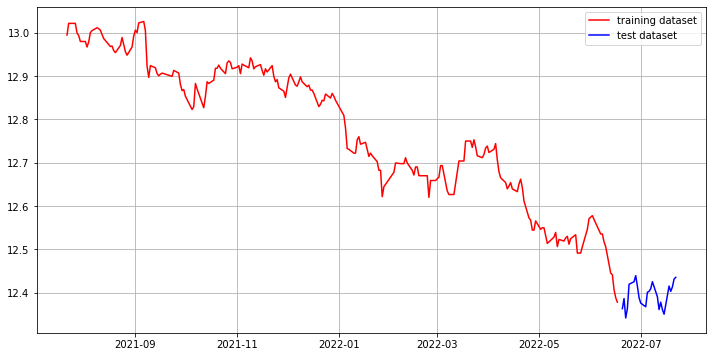

In [27]:
train_naver_data, test_naver_data = ts_naver_log[:int(len(ts_naver_log)*0.9)], ts_naver_log[int(len(ts_naver_log)*0.9):]
plt.figure(figsize=(12,6))
plt.grid(True)
plt.plot(train_naver_data, c='r', label='training dataset')
plt.plot(test_naver_data, c='b', label='test dataset')
plt.legend()

## 5. 적정 ARIMA 모수 찾기

- ACF,PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d구하기

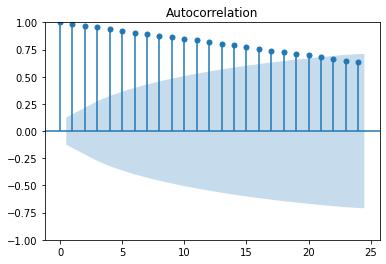

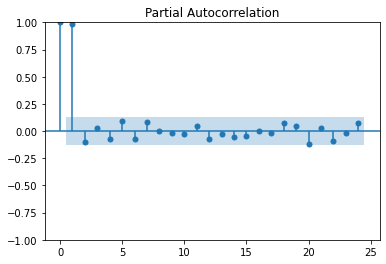

In [28]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_naver_log)
plot_pacf(ts_naver_log)
plt.show()

ACF plot을 보면 서서히 줄어드는 것을 확인할 수 있다. 이는 Staionary하지 않다는 것을 확인할 수 있다. 즉, Adfuller 함수를 통해 알 수 있었던 d 파라미터가 정확하지 않을 수 있다. 그러므로 차분을 진행한다. 그리고 PACF를 보면 lag 1 이후로 0이 된다는 것을 확인할 수 있다. 그러므로 p 파라미터를 1로 생각하고 다음을 진행할 수 있다. 하지만  MAPE값이 최적인 경우는 아직 확인되지 않았기 때문에 확인이 필요하다.

Results of Dickey-Fuller Test:
Test Statisic                 -8.379625e+00
p-value                        2.530729e-13
#Lags Used                     3.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statisic                 -7.427970e+00
p-value                        6.472828e-11
#Lags Used                     1.400000e+01
Number of Observations Used    2.280000e+02
Critical Value (1%)           -3.459361e+00
Critical Value (5%)           -2.874302e+00
Critical Value (10%)          -2.573571e+00
dtype: float64


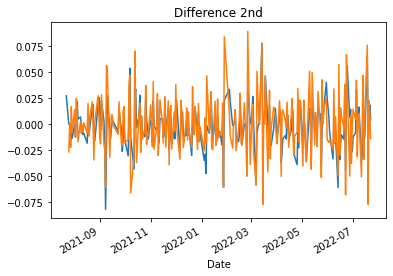

In [29]:
diff_naver_1 = ts_naver_log.diff(periods=1).iloc[1:]
diff_naver_1.plot(title='Diffenrences 1st')

augmented_dickey_fuller_test(diff_naver_1)

diff_naver_2 = diff_naver_1.diff(periods=1).iloc[1:]
diff_naver_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_naver_2)

## 6. ARIMA 모델 훈련과 테스트

- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [63]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_naver_data, order=(1,0,1))
fitted_naver_m = model.fit()

print(fitted_naver_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  220
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 546.276
Date:                Mon, 25 Jul 2022   AIC                          -1084.553
Time:                        01:29:24   BIC                          -1070.978
Sample:                             0   HQIC                         -1079.071
                                - 220                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.7136      0.204     62.332      0.000      12.314      13.113
ar.L1          0.9957      0.010    100.865      0.000       0.976       1.015
ma.L1          0.1656      0.071      2.315      0.0

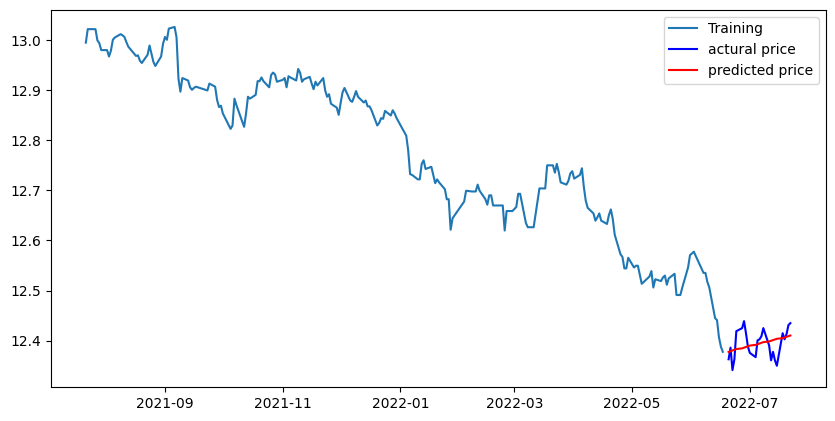

In [64]:
fc_naver = fitted_naver_m.forecast(len(test_naver_data), alpha=0.05) # 신뢰구간 95%
fc_naver = np.array(fc_naver)
fc_naver_series = pd.Series(fc_naver, index=test_naver_data.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_naver_data, label='Training')
plt.plot(test_naver_data, c='b', label='actural price')
plt.plot(fc_naver_series, c='r', label='predicted price')
plt.legend()
plt.show()

In [65]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_naver_data), np.exp(fc_naver))
print('MSE : ', mse)

mae = mean_absolute_error(np.exp(test_naver_data), np.exp(fc_naver))
print('MAE : ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_naver_data), np.exp(fc_naver)))
print('RMSE : ', rmse)

mape = np.mean(np.abs(np.exp(fc_naver)-np.exp(test_naver_data))/np.abs(np.exp(test_naver_data)))
print('MAPE: {:2f}%'.format(mape*100))


MSE :  42984028.30574565
MAE :  5445.771367099066
RMSE :  6556.220580925084
MAPE: 2.260426%


위에서 d파라미터를 0 또는 1이라 생각하고 p 파라미터를 1이라고 생각했다. 위에서 분석한대로 p파라미터 1, d파라미터0, q파라미터 1인것을 확인할 수 있다.

## 카카오 주식 분석

## 1. 필요한 데이터 불러오기

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import statsmodels
import sklearn

import warnings
warnings.filterwarnings('ignore')

In [34]:
dataset_kakao_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/035720.KS.csv'
df_kakao = pd.read_csv(dataset_kakao_filepath, index_col='Date', parse_dates=True)
ts_kakao = df_kakao['Close']

In [35]:
ts_kakao.head()

Date
2021-07-22    148584.671875
2021-07-23    150599.375000
2021-07-26    148584.671875
2021-07-27    149088.343750
2021-07-28    149088.343750
Name: Close, dtype: float64

## 2. 각종 필요한 전처리

- 결측치 확인
- 로그 변환

In [36]:
# 결측치 확인
ts_kakao = ts_kakao.interpolate(method='time')
ts_kakao[ts_kakao.isna()]

Series([], Name: Close, dtype: float64)

In [37]:
# 로그 변환
ts_kakao_log = np.log(ts_kakao)

## 3. 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

### 필요한 함수 정의 
- 이동평균과 이동표준편차 함수 
- Augmented Dicky-Fuller Test함수 

In [38]:
def plot_rolling_statics(timeseries, window=12):
  rolmean = timeseries.rolling(window=window).mean()
  rolstd = timeseries.rolling(window=window).std()

  orig = plt.plot(timeseries, color = 'blue', label ='Original')
  mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
  std = plt.plot(rolstd, color = 'black', label ='Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)

In [39]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
  dftest = adfuller(timeseries, autolag='AIC')

  print('Results of Dickey-Fuller Test:')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statisic', 'p-value', '#Lags Used', 'Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key] = value
  print(dfoutput)

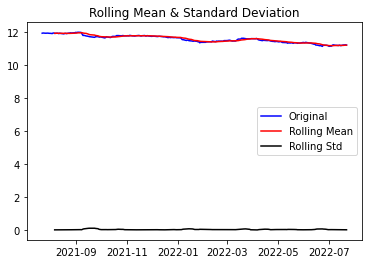

Results of Dickey-Fuller Test:
Test Statisic                   -0.876423
p-value                          0.795637
#Lags Used                       3.000000
Number of Observations Used    241.000000
Critical Value (1%)             -3.457779
Critical Value (5%)             -2.873609
Critical Value (10%)            -2.573202
dtype: float64


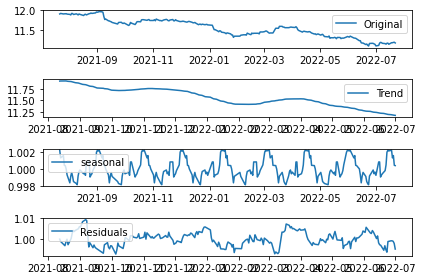

In [40]:
# 정성적 그래프 분석
plot_rolling_statics(ts_kakao_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_kakao_log)

# 시계열 분해(Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
kakao_decomposition = seasonal_decompose(ts_kakao_log, model= 'multiplicative', period=30)

trend = kakao_decomposition.trend
seasonal = kakao_decomposition.seasonal
residual = kakao_decomposition.resid

plt.subplot(411)
plt.plot(ts_kakao_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc='best')
plt.tight_layout()

Adfuller()함수를 통해서 우리는 시계열 데이터가 Stationary하다는 것을 알 수 있다. 왜냐하면 Critical Value보다 각각 낮은 값을 가지고 있기 때문이다. 그렇기 때문에 d 파라미터를 0으로 생각할 수 있다. 하지만 위와 마찬가지로 ACFplot이 Stationary하지 않다고 판단할 수 있기 때문에 우리는 d파라미터를 확정지으면 안된다.

In [41]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statisic                   -4.332571
p-value                          0.000390
#Lags Used                       3.000000
Number of Observations Used    211.000000
Critical Value (1%)             -3.461727
Critical Value (5%)             -2.875337
Critical Value (10%)            -2.574124
dtype: float64


## 4. 학습 & 테스트 데이터셋 생성

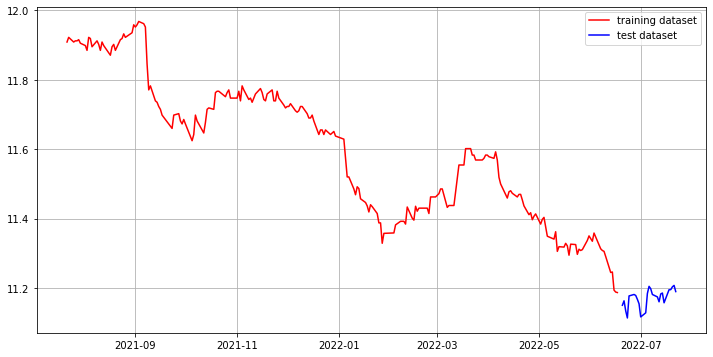

In [42]:
train_kakao_data, test_kakao_data = ts_kakao_log[:int(len(ts_kakao_log)*0.9)], ts_kakao_log[int(len(ts_kakao_log)*0.9):]
plt.figure(figsize=(12,6))
plt.grid(True)
plt.plot(train_kakao_data, c='r', label='training dataset')
plt.plot(test_kakao_data, c='b', label='test dataset')
plt.legend()

## 5. 적정 ARIMA 모수 찾기

- ACF,PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d구하기

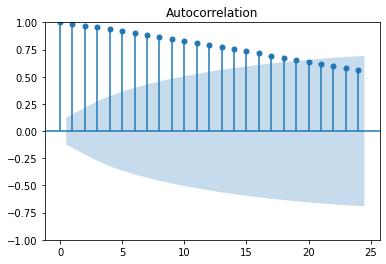

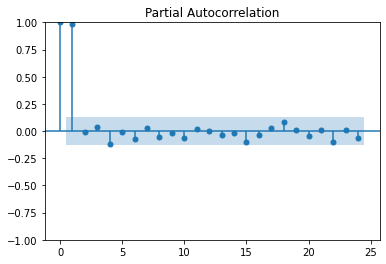

In [43]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_kakao_log)
plot_pacf(ts_kakao_log)
plt.show()

ACFplot을 봤을 때 비정상적인 시계열 데이터임을 확인할 수 있다. PACFplot을 봤을 때 lag1일 이후로 0 이후로 0이 되기 때문에 p 파라미터 값은 1로 설정하는 것이 좋을 것 같다. 그러나 다른 파라미터 값을 넣어서도 최적의 값을 찾을 수 있기 때문에 여러 파라미터를 넣어보고 확인해본다.

Results of Dickey-Fuller Test:
Test Statisic                 -7.868874e+00
p-value                        5.047696e-12
#Lags Used                     2.000000e+00
Number of Observations Used    2.410000e+02
Critical Value (1%)           -3.457779e+00
Critical Value (5%)           -2.873609e+00
Critical Value (10%)          -2.573202e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statisic                 -7.793510e+00
p-value                        7.827558e-12
#Lags Used                     1.000000e+01
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critical Value (10%)          -2.573453e+00
dtype: float64


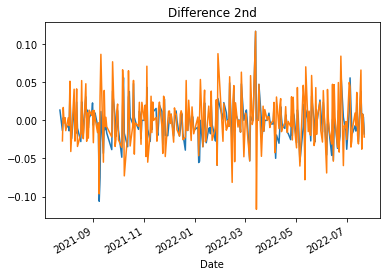

In [44]:
diff_kakao_1 = ts_kakao_log.diff(periods=1).iloc[1:]
diff_kakao_1.plot(title='Diffenrences 1st')

augmented_dickey_fuller_test(diff_kakao_1)

diff_kakao_2 = diff_kakao_1.diff(periods=1).iloc[1:]
diff_kakao_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_kakao_2)

2차 차분을 진행한 것보다 1차 차분한 그래프가 오히려 분산이 더 적은 것을 확인할 수 있다. 앞서 확인했던 Adfuller()함수에서 나왔던 d파라미터를 생각하면서 두 가지 모두 진행해 MAPE의 값이 더 최적의 값을 가지는 것을 확인한다.

## 6. ARIMA 모델 훈련과 테스트

- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [87]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_kakao_data, order=(2,1,1))
fitted_kakao_m = model.fit()

print(fitted_kakao_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  220
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 508.009
Date:                Mon, 25 Jul 2022   AIC                          -1008.018
Time:                        01:33:45   BIC                           -994.461
Sample:                             0   HQIC                         -1002.543
                                - 220                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6992      0.246     -2.839      0.005      -1.182      -0.216
ar.L2         -0.0985      0.091     -1.077      0.282      -0.278       0.081
ma.L1          0.7278      0.256      2.848      0.0

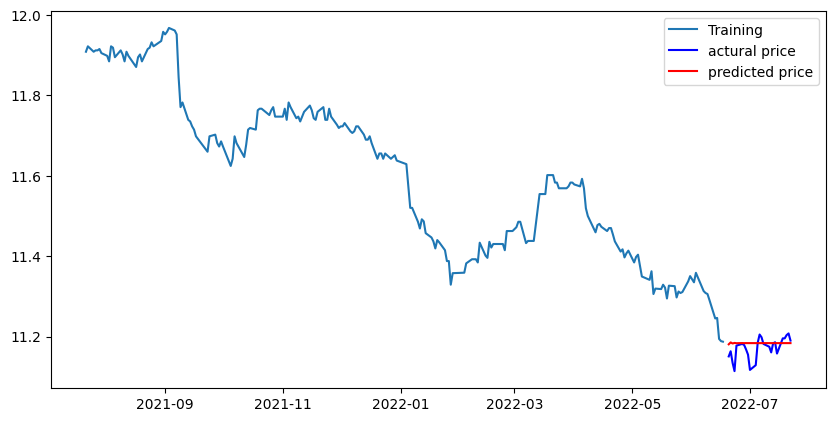

In [88]:
fc_kakao = fitted_kakao_m.forecast(len(test_kakao_data), alpha=0.05)
fc_kakao = np.array(fc_kakao)
fc_kakao_series = pd.Series(fc_kakao, index=test_kakao_data.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_kakao_data, label='Training')
plt.plot(test_kakao_data, c='b', label='actural price')
plt.plot(fc_kakao_series, c='r', label='predicted price')
plt.legend()
plt.show()

In [89]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_kakao_data), np.exp(fc_kakao))
print('MSE : ', mse)

mae = mean_absolute_error(np.exp(test_kakao_data), np.exp(fc_kakao))
print('MAE : ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_kakao_data), np.exp(fc_kakao)))
print('RMSE : ', rmse)

mape = np.mean(np.abs(np.exp(fc_kakao)-np.exp(test_kakao_data))/np.abs(np.exp(test_kakao_data)))
print('MAPE: {:2f}%'.format(mape*100))


MSE :  4053891.2903268426
MAE :  1483.0665932204754
RMSE :  2013.4277464877757
MAPE: 2.127971%


앞에서 분석한대로 p파라미터는 1, d 파라미터는 0또는 1이라고 생각했다. 그러나 MAPE값의 최적인 값은 p파라미터가 2인 경우였다. 이와 같이 주의를 기울이면서 MAPE값이 최적인 값을 찾아야 한다.

# 자료출처

1. Aiffel Exploration #4
2. Augumented Dickey-Fuller test https://dodonam.tistory.com/235
3. MAPE 정의 https://acdongpgm.tistory.com/102

# 회고

주식을 분석하는 것은 재무제표로만 할 수 있는줄 알았는데 시계열을 통한 분석이 새롭게 다가왔다. 그리고 과거의 값 혹은 에러를 통해서 미래를 예측할 수 있다는 사실이 새롭다. ARIMA모델을 실제로 경험하면서 좀 더 깊은 이해를 할 수 있었던 것 같다. 데이터 분석은 늘 새로운 경험인 것 같다.